<a href="https://colab.research.google.com/github/ramswaroopbhakar14/Upvotes-prediction/blob/master/Upvote_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/ramswaroopbhakar14/Upvotes-prediction.git

Cloning into 'Upvotes-prediction'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 3), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
%cd /content/Upvotes-prediction/data

/content/Upvotes-prediction/data


In [0]:
import pandas as pd
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

"creating copy of both train & test for further uses"
train_data1 = train_data.copy()
test_data1 = test_data.copy()

In [4]:
print("train columns:\n",train_data.columns)
print("test columns:\n",test_data.columns)

train columns:
 Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')
test columns:
 Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views'], dtype='object')


Print train & test head data

In [5]:
print("train sample:\n",train_data.head())
print("test sample:\n",test_data.head())

train sample:
        ID Tag  Reputation  Answers  Username    Views  Upvotes
0   52664   a      3942.0      2.0    155623   7855.0     42.0
1  327662   a     26046.0     12.0     21781  55801.0   1175.0
2  468453   c      1358.0      4.0     56177   8067.0     60.0
3   96996   a       264.0      3.0    168793  27064.0      9.0
4  131465   c      4271.0      4.0    112223  13986.0     83.0
test sample:
        ID Tag  Reputation  Answers  Username    Views
0  366953   a      5645.0      3.0     50652  33200.0
1   71864   c     24511.0      6.0     37685   2730.0
2  141692   i       927.0      1.0    135293  21167.0
3  316833   i        21.0      6.0    166998  18528.0
4  440445   i      4475.0     10.0     53504  57240.0


dropping non-important features

In [0]:
train_data = train_data1.drop(columns=['ID','Username'])
test_data = test_data1.drop(columns=['ID','Username'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


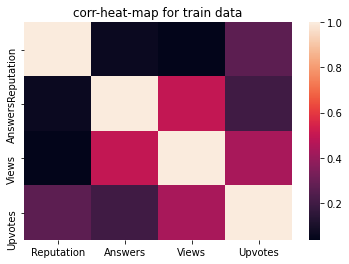

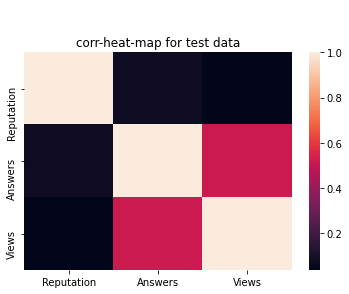

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
plt.title("corr-heat-map for train data")
"find correlation matrix"
train_corr = train_data.corr()
"generating heatmap using train_corr"
sns.heatmap(train_corr) # we don't see any var-pair haivng > 0.5 correlation, hence we'll be directly going for model building

plt.figure()
plt.title("\n\ncorr-heat-map for test data")
"find correlation matrix for test data"
test_corr = test_data.corr()
"generating heatmap using test_corr"
sns.heatmap(test_corr) 

Converting car=tegorical to numerical features ('Tag')

In [0]:
"Converting categorical str to continuous form usig dummy variables"
train_data = pd.concat([train_data.loc[:, train_data.columns!='Tag'], pd.get_dummies(train_data[['Tag']])], axis=1)
test_data = pd.concat([test_data.loc[:, test_data.columns!='Tag'], pd.get_dummies(test_data[['Tag']])], axis=1)

In [9]:
print("train columns:\n",train_data.columns)
print("test columns:\n",test_data.columns)

train columns:
 Index(['Reputation', 'Answers', 'Views', 'Upvotes', 'Tag_a', 'Tag_c', 'Tag_h',
       'Tag_i', 'Tag_j', 'Tag_o', 'Tag_p', 'Tag_r', 'Tag_s', 'Tag_x'],
      dtype='object')
test columns:
 Index(['Reputation', 'Answers', 'Views', 'Tag_a', 'Tag_c', 'Tag_h', 'Tag_i',
       'Tag_j', 'Tag_o', 'Tag_p', 'Tag_r', 'Tag_s', 'Tag_x'],
      dtype='object')


In [10]:
"data pre-processing"
train_summary = train_data.describe()
test_summary = test_data.describe()

print(train_summary)
print(test_summary)

"missing data summary"
summary_na_train= [train_data[x].isna().sum() for x in train_data.columns] # we don't have any nan values in this data
summary_na_test= [test_data[x].isna().sum() for x in test_data.columns] # we don't have any nan values in this data

print(summary_na_train)
print(summary_na_test)

         Reputation        Answers  ...          Tag_s          Tag_x
count  3.300450e+05  330045.000000  ...  330045.000000  330045.000000
mean   7.773147e+03       3.917672  ...       0.070666       0.021143
std    2.706141e+04       3.579515  ...       0.256267       0.143860
min    0.000000e+00       0.000000  ...       0.000000       0.000000
25%    2.820000e+02       2.000000  ...       0.000000       0.000000
50%    1.236000e+03       3.000000  ...       0.000000       0.000000
75%    5.118000e+03       5.000000  ...       0.000000       0.000000
max    1.042428e+06      76.000000  ...       1.000000       1.000000

[8 rows x 14 columns]
         Reputation        Answers  ...          Tag_s          Tag_x
count  1.414480e+05  141448.000000  ...  141448.000000  141448.000000
mean   7.920927e+03       3.914873  ...       0.071319       0.021167
std    2.791072e+04       3.577460  ...       0.257359       0.143941
min    0.000000e+00       0.000000  ...       0.000000       0.0000

Feature standardization scaling

In [0]:
from sklearn.preprocessing import StandardScaler
"fitting & transforming on train data"
sc_fit = StandardScaler().fit(train_data.iloc[:, train_data.columns!='Upvotes'].values)
train_input_scaled = sc_fit.transform(train_data.iloc[:, train_data.columns!='Upvotes'].values)
"transforming on test data"
test_input_scaled = sc_fit.transform(test_data.values)

In [15]:
print('scaled train data inputs:\n',train_input_scaled[:2])
print('scaled test data inputs:\n',test_input_scaled[:2])

scaled train data inputs:
 [[-0.14157253 -0.53573597 -0.26915833  3.06808681 -0.53037275 -0.25777263
  -0.32993107 -0.52931282 -0.21472015 -0.38914639 -0.19792598 -0.27575268
  -0.14696678]
 [ 0.67523751  2.25794312  0.32308687  3.06808681 -0.53037275 -0.25777263
  -0.32993107 -0.52931282 -0.21472015 -0.38914639 -0.19792598 -0.27575268
  -0.14696678]]
scaled test data inputs:
 [[-0.0786415  -0.25636806  0.04391168  3.06808681 -0.53037275 -0.25777263
  -0.32993107 -0.52931282 -0.21472015 -0.38914639 -0.19792598 -0.27575268
  -0.14696678]
 [ 0.61851459  0.58173567 -0.33246406 -0.32593602  1.88546641 -0.25777263
  -0.32993107 -0.52931282 -0.21472015 -0.38914639 -0.19792598 -0.27575268
  -0.14696678]]


Standard scaling of datasets

In [0]:
"splitting train-test data"
from sklearn.model_selection import train_test_split


input_features = train_input_scaled
target = train_data['Upvotes'].values

X_train, X_val, y_train, y_val = train_test_split(input_features, target, random_state=10)


"ML models"
# we'll try 6 different models to get best model with best hyper-parameters
# will use gridsearchcv o randomizedsearchcv for parameter optimization
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLars
from xgboost import XGBRegressor
from sklearn.svm import SVR

poly5 = PolynomialFeatures(3)

llr = LassoLars()
knn = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgbr = XGBRegressor()
svr = SVR()

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

algos = [llr, knn, svr, rfr, xgbr]
grid_params = {llr: {'alpha':[0,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10]},
                 knn:{'n_neighbors':[1,3,5,11,15,17,20,30,40,50,70],'weights':['uniform','distance'],'metric':['euclidean','manhattan']},
                 svr:{'C': [0.1, 1, 10, 100, 1000],'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                  rfr: {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],# Number of trees in random forest
                                                 'max_features': ['auto', 'sqrt',None],# Number of features to consider at every split
                                                 'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]+[None],# Maximum number of levels in tree
                                                 'min_samples_split': [2, 5, 10],# Minimum number of samples required to split a node
                                                 'min_samples_leaf': [1, 2, 4],# Minimum number of samples required at each leaf node
                                                 'bootstrap': [True, False]},# Method of selecting samples for training each tree
                 xgbr:{'eta':[0.1,0.3,0.5,0.7],'gamma':[0,10,100],'max_depth':[1,3,5,9,11]}}                                     


In [20]:
#%%
import time
scoring='neg_mean_squared_error'
cv_results_list = []
best_params_list = []
best_cv_rmse_list = []
val_rmse_list = []
train_time_list = []
for algo in algos[:1]:
    num_iter = 20
    st = time.time()
#    model = GridSearchCV(knn, grid_params[knn], n_jobs=-1, scoring=scoring) # not performing gridsearchcv as it takes lot time
    total_param_combinations = np.prod([len(grid_params[algo][par]) for par in list(grid_params[algo].keys())])
    print("train param, combinations:\n",total_param_combinations)
    
    if algo==llr:
        X_train1 = poly5.fit_transform(X_train)
        model = GridSearchCV(estimator=algo, cv=3, scoring=scoring,n_jobs=-1, param_grid=grid_params[algo], refit=True)
        model.fit(X_train1, y_train)
    else:
        model = RandomizedSearchCV(estimator=algo, n_iter=num_iter, cv=3, scoring=scoring,n_jobs=-1, param_distributions=grid_params[algo], refit=True)
        model.fit(X_train, y_train)
    
    
    cv_results_list+=[model.cv_results_]
    
    best_cv_rmse1 = np.sqrt(-max(model.cv_results_['mean_test_score']))
    best_cv_rmse_list+=[best_cv_rmse1]
    
    best_params_list+=[model.best_params_]
    
    train_time1 = str(round(time.time()-st,2))+' seconds'
    train_time_list+=[train_time1]
    if algo==llr:
        X_val1 = poly5.transform(X_val)
        y_pred = model.predict(X_val1)
    else:
        y_pred = model.predict(X_val)
    
    rmse1 = np.sqrt(mse(y_val,y_pred))
        
    val_rmse_list+=[rmse1]
    
    print('total_cv_time:',train_time1)
    print('avg_cv_rmse:',best_cv_rmse1)
    
    print('val_rmse:', rmse1)

train param, combinations:
 12


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


total_cv_time: 91.48 seconds
avg_cv_rmse: 1131.3502170925633
val_rmse: 1390.1705840563795


In [21]:
best_params_list

[{'alpha': 0.05}]

In [0]:
test_data = pd.read_csv('test_data.csv')

In [0]:
test_data.columns

Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views'], dtype='object')

In [0]:
test_data.head()

,ID,Tag,Reputation,Answers,Username,Views
0,366953,a,5645.0,3.0,50652,33200.0
1,71864,c,24511.0,6.0,37685,2730.0
2,141692,i,927.0,1.0,135293,21167.0
3,316833,i,21.0,6.0,166998,18528.0
4,440445,i,4475.0,10.0,53504,57240.0


In [0]:
"Converting categorical str to continuous form usig dummy variables"
test_data1 = pd.concat([test_data.loc[:, test_data.columns!='Tag'], pd.get_dummies(test_data[['Tag']])], axis=1)

test_inputs = test_data1.drop(columns=['ID','Username']).values

In [0]:
final_pred = model.predict(test_inputs)
final_submission = pd.DataFrame({'ID':list(test_data.ID),'Upvotes':list(final_pred)})

In [0]:
!git add -A

hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> data/Upvotes-prediction
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached data/Upvotes-prediction
hint: 
hint: See "git help submodule" for more information.


In [0]:
final_submission.to_csv(r'D:\Analytics vidhya\Predict number of upvotes\data\submission_xgbr_20.csv')

In [0]:
from google.colab import files
final_submission.to_csv('filename.csv') 
files.download('filename.csv')

MessageError: ignored